In [10]:
!pip install chromadb

In [11]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from chromadb.config import Settings
from chromadb import Client

In [12]:
# Step 1: Define image preprocessing and embedding extraction
class ImageEmbedder:
    def __init__(self):
        # Use a pre-trained model (e.g., ResNet) for embedding extraction
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.model.fc = torch.nn.Identity()  # Remove the final classification layer
        self.model.eval()

        # Define image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def extract_embedding(self, image_path):
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.transform(image).unsqueeze(0)
        with torch.no_grad():
            embedding = self.model(image_tensor).squeeze().numpy()
        return embedding



In [13]:
# Step 2: Initialize ChromaDB client
client = Client(Settings())
collection = client.get_or_create_collection(name="image_collection")

In [14]:
# Step 3: Add images to the vector database
# Step 3: do not compile the code in this cell
image_embedder = ImageEmbedder()
image_paths = ["/content/sample_data/image1.jpg", "/content/sample_data/image2.jpg", "/content/sample_data/image3.jpg"]  # Replace with your image paths

for idx, image_path in enumerate(image_paths):
    embedding = image_embedder.extract_embedding(image_path)
    # The 'add' method expects 'documents', 'ids', and 'metadatas' as arguments.
    # We're adapting the code to provide the data in this format.
    collection.add(
        documents=[str(embedding)],  # Convert embedding to string
        ids=[f"img_{idx}"],
        metadatas=[{"path": image_path}]
    )

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [15]:
# Step 3: Add images to the vector database
# Step 3: I have changed the code slightly
# Step 3: Instead of converting the embedding to a string, pass it directly as a list

image_embedder = ImageEmbedder()
image_paths = ["/content/sample_data/image1.jpg", "/content/sample_data/image2.jpg", "/content/sample_data/image3.jpg"]  # Replace with your image paths

# Delete the existing collection to ensure consistent dimensionality
client.delete_collection(name="image_collection")
collection = client.get_or_create_collection(name="image_collection") # Recreate the collection

for idx, image_path in enumerate(image_paths):
    embedding = image_embedder.extract_embedding(image_path)
    # Instead of converting the embedding to a string, pass it directly as a list
    collection.add(
        embeddings=[embedding.tolist()],  # Pass embedding as a list
        ids=[f"img_{idx}"],
        metadatas=[{"path": image_path}]
    )

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


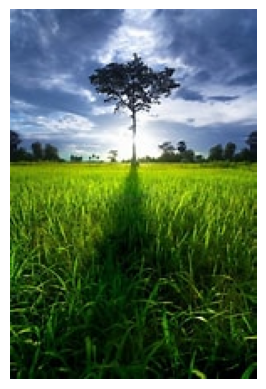

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image
image_path1 = "/content/sample_data/image1.jpg"
image_path2 = "/content/sample_data/image2.jpg"
image_path3 = "/content/sample_data/image3.jpg"


# Load and display the image
img1 = mpimg.imread(image_path1)
img2 = mpimg.imread(image_path2)
img3 = mpimg.imread(image_path3)
#plt.imshow(img1)
#plt.imshow(img2)
plt.imshow(img3)

plt.axis('off')  # Remove axes for better visualization
plt.show()

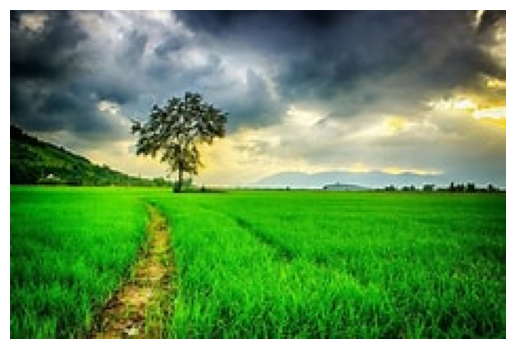

In [17]:
plt.imshow(img1)
plt.axis('off')  # Remove axes for better visualization
plt.show()

In [18]:

# Step 4: Perform similarity search
def search_similar_images(query_image_path, top_k=3):
    query_embedding = image_embedder.extract_embedding(query_image_path)
    results = collection.query(query_embeddings=[query_embedding], n_results=top_k)
    # Accessing the first element of each metadata list, assuming it's a dictionary
    for result in results["metadatas"]:
        print("Similar Image:", result[0]["path"]) # Accessing the first element of each metadata list

In [20]:
# Test similarity search
query_image = "/content/sample_data/sample-image.jpg"  # Replace with your query image path
search_similar_images(query_image, top_k=3)

Similar Image: /content/sample_data/image1.jpg


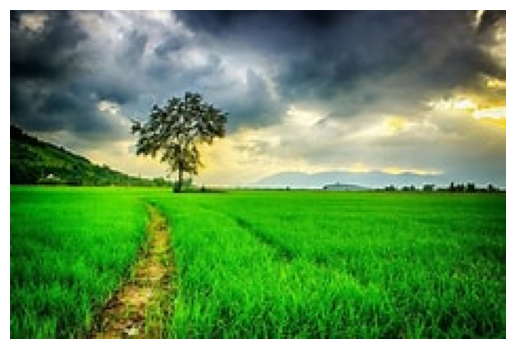

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image
image_path = "/content/sample_data/sample-image.jpg"

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Remove axes for better visualization
plt.show()
